In [1]:
import os
import sys
import glob, csv
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import fisher_exact


In [16]:
alkaline_node_list = [79,112,123,129,133,113,80,93,97,136,138,120, "g0009", "g0011", "g0012", "g0013", "g0014", "g0015", "g0016", "g0017", "g0029", "g0030", "g0031", "g0032", "g0033", "g0034", "g0035", 'g0036']

In [17]:
cutoff = 0.5        # adjust for stringency

df_full = pd.read_csv('Events_at_all_nodes.csv',header=0)
df_copies = df_full[['Node','Gene Family','Copies']]
df_copies_filt = df_copies.loc[df_copies['Copies'] >= cutoff]      
df_copies_filt['alkaline_or_not'] = np.where(np.isin(df_copies_filt['Node'],alkaline_node_list), "alkaline", "not_alkaline")

/var/folders/6c/dkl_rmf913l9h4s3pys_spm80000gn/T/ipykernel_5511/2759371361.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copies_filt['alkaline_or_not'] = np.where(np.isin(df_copies_filt['Node'],alkaline_node_list), "alkaline", "not_alkaline")


In [18]:
df_copies_filt

Node                               Gene Family  Copies  \
4        g0003     pmsf_0_MSA_trimmed.ufboot.ale.uml_rec    1.00   
5        g0004     pmsf_0_MSA_trimmed.ufboot.ale.uml_rec    1.00   
18       g0018     pmsf_0_MSA_trimmed.ufboot.ale.uml_rec    1.00   
19       g0019     pmsf_0_MSA_trimmed.ufboot.ale.uml_rec    1.00   
76          75     pmsf_0_MSA_trimmed.ufboot.ale.uml_rec    1.00   
...        ...                                       ...     ...   
1158938    136  pmsf_9984_MSA_trimmed.ufboot.ale.uml_rec    0.51   
1158939    137  pmsf_9984_MSA_trimmed.ufboot.ale.uml_rec    0.80   
1158940    138  pmsf_9984_MSA_trimmed.ufboot.ale.uml_rec    0.55   
1158941    139  pmsf_9984_MSA_trimmed.ufboot.ale.uml_rec    0.79   
1158942    140  pmsf_9984_MSA_trimmed.ufboot.ale.uml_rec    0.61   

        alkaline_or_not  
4          not_alkaline  
5          not_alkaline  
18         not_alkaline  
19         not_alkaline  
76         not_alkaline  
...                 ...  
1158938        alkaline  
1158939    not_alkaline  
1158940        alkaline  
1158941    not_alkaline  
1158942    not_alkaline  

[161072 rows x 4 columns]

In [19]:
# Creating a gene matrix

gene_matrix = df_copies_filt.pivot(index='Node', columns='Gene Family', values='Copies').fillna(0)
print(gene_matrix)


Gene Family  pmsf_0_MSA_trimmed.ufboot.ale.uml_rec  \
Node                                                 
100                                            0.0   
101                                            0.0   
102                                            0.0   
103                                            0.0   
104                                            0.0   
...                                            ...   
g990078                                        0.0   
g990079                                        0.0   
g990080                                        0.0   
g990081                                        0.0   
g990082                                        0.0   

Gene Family  pmsf_10003_MSA_trimmed.ufboot.ale.uml_rec  \
Node                                                     
100                                                0.0   
101                                                0.0   
102                                                0.0   
103    

In [20]:

# convert to binary data
binary_matrix = (gene_matrix > 0).astype(int)
# print(binary_matrix)

In [21]:
# Creating a labels series

labels = df_copies_filt[['Node','alkaline_or_not']].drop_duplicates(['Node','alkaline_or_not']).drop('Node', axis=1)
labels = labels.squeeze()
labels.index = binary_matrix.index
print(labels)

Node
100        not_alkaline
101        not_alkaline
102        not_alkaline
103        not_alkaline
104        not_alkaline
               ...     
g990078    not_alkaline
g990079    not_alkaline
g990080    not_alkaline
g990081    not_alkaline
g990082    not_alkaline
Name: alkaline_or_not, Length: 147, dtype: object


## Fisher's Exact Test

For testing significance of gene enrichment/depletion
- Only binary data - have to turn counts to binary

### Run the Fisher's test

For each gene family in a loop and then convert to dataframe

#### Interpretation of the Odds Ratio (OR)
**OR = 1:** This indicates no association between the gene family and the genome type (alkaline vs. non-alkaline). The odds of presence in alkaline genomes are the same as the odds of presence in non-alkaline genomes.

**OR > 1:** This indicates a positive association between the gene family and alkaline genomes. The gene family is more likely to be present in alkaline genomes compared to non-alkaline genomes.
The further the OR is greater than 1, the stronger the association. For example, an OR of 2 means that alkaline genomes are twice as likely to have the gene family present compared to non-alkaline genomes.

**OR < 1:** This indicates a negative association between the gene family and alkaline genomes, meaning the gene family is more likely to be absent in alkaline genomes compared to non-alkaline genomes.
The further the OR is less than 1, the stronger the depletion. For example, an OR of 0.5 means that alkaline genomes are half as likely to have the gene family present compared to non-alkaline genomes.

#### Interpretation of the p-value
p-value < 0.05 : significant
p-value > 0.05 : non-significant

A p-value > 0.05 means that the test did not find a statistically significant difference. It does not imply that the gene family is depleted or enriched.

To determine depletion, check the odds ratio (OR). If the OR is less than 1, it suggests depletion, but the p-value must be low (typically < 0.05) for it to be statistically significant.


In [22]:
# Initialize results
results = []

# Loop through each gene family
for gene_family in binary_matrix.columns:
    # Create contingency table
    alkaline_present = binary_matrix.loc[labels == 'alkaline', gene_family].sum()
    non_alkaline_present = binary_matrix.loc[labels == 'not_alkaline', gene_family].sum()
    alkaline_absent = len(labels[labels == 'alkaline']) - alkaline_present
    non_alkaline_absent = len(labels[labels == 'not_alkaline']) - non_alkaline_present

    contingency_table = [
        [alkaline_present, non_alkaline_present],
        [alkaline_absent, non_alkaline_absent]
    ]
    # Perform Fisher's Exact Test
    odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
     # Store results
    results.append({
        'GeneFamily': gene_family,
        'OddsRatio': odds_ratio,
        'PValue': p_value
    })

# Convert results into a DataFrame for easy inspection
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


                                     GeneFamily  OddsRatio    PValue
0         pmsf_0_MSA_trimmed.ufboot.ale.uml_rec   1.753846  0.618331
1     pmsf_10003_MSA_trimmed.ufboot.ale.uml_rec   9.120000  0.000450
2     pmsf_10006_MSA_trimmed.ufboot.ale.uml_rec   3.138889  0.097248
3     pmsf_10008_MSA_trimmed.ufboot.ale.uml_rec   6.277778  0.003402
4     pmsf_10012_MSA_trimmed.ufboot.ale.uml_rec   5.550000  0.002949
...                                         ...        ...       ...
7879   pmsf_9985_MSA_trimmed.ufboot.ale.uml_rec   0.627219  0.736835
7880   pmsf_9986_MSA_trimmed.ufboot.ale.uml_rec   0.000000  0.347144
7881   pmsf_9996_MSA_trimmed.ufboot.ale.uml_rec  11.500000  0.000199
7882   pmsf_9997_MSA_trimmed.ufboot.ale.uml_rec   4.625000  0.009560
7883      pmsf_9_MSA_trimmed.ufboot.ale.uml_rec   8.405797  0.006667

[7884 rows x 3 columns]


### ADJUSTING THE PVALUE USING BENJAMINI-HOCHBERG PROCEDURE for FDR (LESS CONSERVATIVE THAN BONFERRONI)


In [23]:
# Assume `results_df` is the DataFrame containing the original p-values
# that you obtained from Fisher's Exact Test (with 'PValue' column)

# Step 1: Sort p-values in ascending order and assign ranks
results_df['Rank'] = results_df['PValue'].rank(method='min')

# Step 2: Calculate the adjusted p-values using the BH procedure formula
m = len(results_df)  # Total number of tests (gene families)
results_df['BH_Adjusted_PValue'] = results_df['PValue'] * m / results_df['Rank']

# Step 3: Ensure adjusted p-values do not exceed 1
results_df['BH_Adjusted_PValue'] = np.minimum(results_df['BH_Adjusted_PValue'], 1)

# Step 4: Determine which tests are significant after BH correction
results_df['Significant'] = results_df['BH_Adjusted_PValue'] < 0.05

# Display the results
print(results_df)

results_df_filtered = results_df.loc[results_df['PValue'] < 0.05]
print(results_df_filtered)

                                     GeneFamily  OddsRatio    PValue    Rank  \
0         pmsf_0_MSA_trimmed.ufboot.ale.uml_rec   1.753846  0.618331  4325.0   
1     pmsf_10003_MSA_trimmed.ufboot.ale.uml_rec   9.120000  0.000450    33.0   
2     pmsf_10006_MSA_trimmed.ufboot.ale.uml_rec   3.138889  0.097248  1564.0   
3     pmsf_10008_MSA_trimmed.ufboot.ale.uml_rec   6.277778  0.003402   447.0   
4     pmsf_10012_MSA_trimmed.ufboot.ale.uml_rec   5.550000  0.002949   408.0   
...                                         ...        ...       ...     ...   
7879   pmsf_9985_MSA_trimmed.ufboot.ale.uml_rec   0.627219  0.736835  5452.0   
7880   pmsf_9986_MSA_trimmed.ufboot.ale.uml_rec   0.000000  0.347144  2509.0   
7881   pmsf_9996_MSA_trimmed.ufboot.ale.uml_rec  11.500000  0.000199     2.0   
7882   pmsf_9997_MSA_trimmed.ufboot.ale.uml_rec   4.625000  0.009560   834.0   
7883      pmsf_9_MSA_trimmed.ufboot.ale.uml_rec   8.405797  0.006667   645.0   

      BH_Adjusted_PValue  Significant  

Dunno, I am not convinced by this as it is classifying some genes which I know are unique in alkaline as non-significant

### Plotting the significant enriched/depleted genes in alkaline genomes

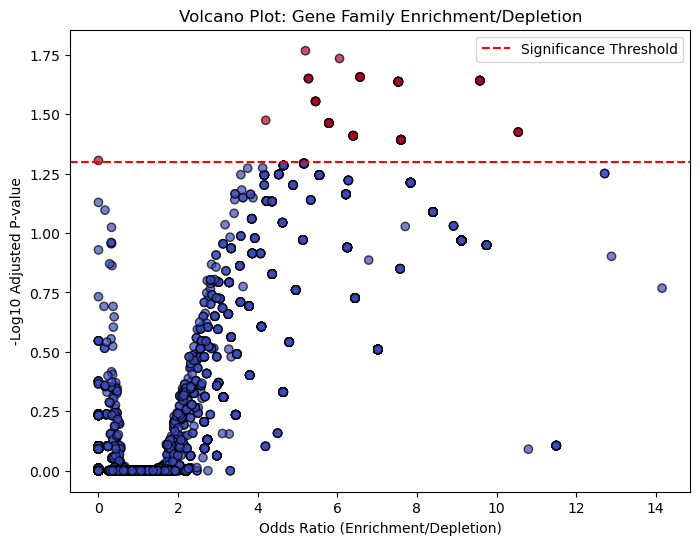

In [24]:
import matplotlib.pyplot as plt

# Assume 'results_df' contains the adjusted p-values and log-fold change (or odds ratio)
# If you don't have log-fold change, you can calculate the odds ratio and take the log2

# Example of adding log-fold change (using Odds Ratio or other measure of effect size)
# results_df['log2_fold_change'] = np.log2(results_df['OddsRatio'])

# Volcano plot
plt.figure(figsize=(8, 6))
plt.scatter(
    results_df['OddsRatio'],  # x-axis: log-fold change (enrichment or depletion)
    -np.log10(results_df['BH_Adjusted_PValue']),  # y-axis: -log10(p-value)
    c=results_df['BH_Adjusted_PValue'] < 0.05,  # Color points by significance (adjusted p-value < 0.05)
    cmap='coolwarm',  # Color map
    edgecolor='k',
    alpha=0.7
)

# Add significance threshold line
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='Significance Threshold')

# Labels and title
plt.title('Volcano Plot: Gene Family Enrichment/Depletion')
plt.xlabel('Odds Ratio (Enrichment/Depletion)')
plt.ylabel('-Log10 Adjusted P-value')
plt.legend()

# Show plot
plt.show()


## Poisson regression
Takes into account count data - non binary


In [25]:
# For one gene family only

import statsmodels.api as sm

# Example: Poisson regression for count data
X = gene_matrix['pmsf_0_MSA_trimmed.ufboot.ale.uml_rec']  # Count data (number of occurrences of a gene family)
y = (labels == 'alkaline').astype(int)  # Binary outcome: Alkaline vs. Non-Alkaline


# Add constant (intercept)
X = sm.add_constant(X)


# Poisson regression model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

print(poisson_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:        alkaline_or_not   No. Observations:                  147
Model:                            GLM   Df Residuals:                      145
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -74.278
Date:                Tue, 10 Dec 2024   Deviance:                       92.555
Time:                        13:32:44   Pearson chi2:                     119.
No. Iterations:                     5   Pseudo R-squ. (CS):           0.002075
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [26]:
import statsmodels.stats.multitest as mt

# Assuming `gene_matrix` is your dataframe of gene family counts
# and `labels` contains the corresponding 'Alkaline' or 'Non-Alkaline' labels

# Initialize a list to store p-values for each gene family
results = []

# Loop through each gene family
for gene_family in gene_matrix.columns:
    # Create the dependent variable (alkaline or not) 
    # assuming 'alkaline_or_not' is a binary column in `labels` (0 = Non-Alkaline, 1 = Alkaline)
    X = gene_matrix[gene_family]
    X = sm.add_constant(X)  # Add intercept to the model
    
    y = (labels == 'alkaline').astype(int)  # Convert labels to binary: 1 for Alkaline, 0 for Non-Alkaline
    
    # Fit Poisson regression model
    poisson_model = sm.GLM(y, X, family=sm.families.Poisson(), link=sm.families.links.log()).fit()
    
    # Get the p-value for the gene family
    results.append({
        'GeneFamily': gene_family,
        'OddsRatio': np.exp(poisson_model.params[gene_family]),
        'PValue': poisson_model.pvalues[gene_family]
    })


/Users/varadakhot/miniconda3/envs/working-env/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/varadakhot/miniconda3/envs/working-env/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['link']
  warnings.warn(msg, ValueWarning)
/Users/varadakhot/miniconda3/envs/working-env/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/varadakhot/miniconda3/envs/working-env/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['link']
  warnings.warn(msg, ValueWarning)
/Users/varadakhot/miniconda3/envs/working-env/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: Future

In [27]:

# Display the results
results_df_pois = pd.DataFrame(results)

# Step 1: Sort p-values in ascending order and assign ranks
results_df_pois['Rank'] = results_df_pois['PValue'].rank(method='min')

# Step 2: Calculate the adjusted p-values using the BH procedure formula
m = len(results_df_pois)  # Total number of tests (gene families)
results_df_pois['BH_Adjusted_PValue'] = results_df_pois['PValue'] * m / results_df_pois['Rank']

# Step 3: Ensure adjusted p-values do not exceed 1
results_df_pois['BH_Adjusted_PValue'] = np.minimum(results_df_pois['BH_Adjusted_PValue'], 1)

# Step 4: Determine which tests are significant after BH correction
results_df_pois['Significant'] = results_df_pois['BH_Adjusted_PValue'] < 0.05

# Display the results
print(results_df_pois)

# filtered cos it gave me some really weird odds ratios
results_df_pois_filt = results_df_pois.loc[(results_df_pois['OddsRatio'] < 50) & (results_df_pois['OddsRatio'] > 0.01)]#& ] (results_df['BH_Adjusted_PValue'] < 0.05)
print(results_df_filtered) 

# Optional: Identify significant gene families (adjusted p-value < 0.05)
# significant_gene_families = results[results['PValue'] < 0.05]
# print("Significant Gene Families:")
# print(significant_gene_families)


                                     GeneFamily     OddsRatio    PValue  \
0         pmsf_0_MSA_trimmed.ufboot.ale.uml_rec  1.538462e+00  0.557164   
1     pmsf_10003_MSA_trimmed.ufboot.ale.uml_rec  2.245350e+00  0.002897   
2     pmsf_10006_MSA_trimmed.ufboot.ale.uml_rec  2.283333e+00  0.126318   
3     pmsf_10008_MSA_trimmed.ufboot.ale.uml_rec  2.319549e+00  0.008559   
4     pmsf_10012_MSA_trimmed.ufboot.ale.uml_rec  2.126729e+00  0.007364   
...                                         ...           ...       ...   
7879   pmsf_9985_MSA_trimmed.ufboot.ale.uml_rec  5.968588e-01  0.522554   
7880   pmsf_9986_MSA_trimmed.ufboot.ale.uml_rec  9.815017e-10  0.998989   
7881   pmsf_9996_MSA_trimmed.ufboot.ale.uml_rec  2.704114e+00  0.000990   
7882   pmsf_9997_MSA_trimmed.ufboot.ale.uml_rec  2.933333e+00  0.013673   
7883      pmsf_9_MSA_trimmed.ufboot.ale.uml_rec  3.777174e+00  0.007075   

        Rank  BH_Adjusted_PValue  Significant  
0     3387.0            1.000000        False  
1  

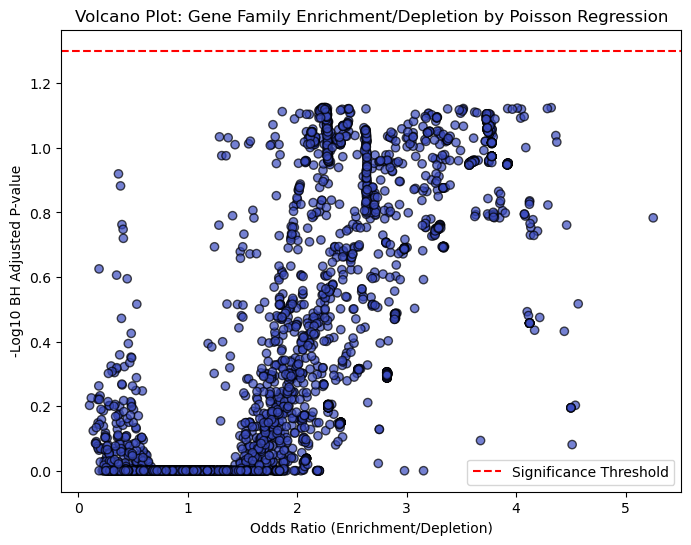

In [28]:
# Volcano plot
plt.figure(figsize=(8, 6))
plt.scatter(
    results_df_pois_filt['OddsRatio'],  # x-axis: log-fold change (enrichment or depletion)
    -np.log10(results_df_pois_filt['BH_Adjusted_PValue']),  # y-axis: -log10(p-value)
    c=results_df_pois_filt['BH_Adjusted_PValue'] < 0.05,  # Color points by significance (adjusted p-value < 0.05)
    cmap='coolwarm',  # Color map
    edgecolor='k',
    alpha=0.7
)

# Add significance threshold line
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='Significance Threshold')

# Labels and title
plt.title('Volcano Plot: Gene Family Enrichment/Depletion by Poisson Regression')
plt.xlabel('Odds Ratio (Enrichment/Depletion)')
plt.ylabel('-Log10 BH Adjusted P-value')
plt.legend()

# Show plot
plt.show()

In [30]:
# from Fisher's test

results_df_filt = results_df.loc[results_df['BH_Adjusted_PValue'] < 0.05]
results_df_filt

# from Poisson regression
results_df_pois_filt_2 = results_df_pois_filt.loc[results_df_pois_filt['BH_Adjusted_PValue'] < 0.05]
results_df_pois_filt_2

Empty DataFrame
Columns: [GeneFamily, OddsRatio, PValue, Rank, BH_Adjusted_PValue, Significant]
Index: []

In [31]:
# merged the two tests

df_test_merged = pd.merge(results_df,results_df_pois_filt, how='outer', on='GeneFamily', suffixes=['_Fisher', '_Poisson'])
print(df_test_merged)
df_test_merged = df_test_merged.loc[(df_test_merged['BH_Adjusted_PValue_Fisher'] < 0.05) | (df_test_merged['BH_Adjusted_PValue_Poisson'] < 0.05)]
df_test_merged
# df_test_merged.drop(['Rank','BH_Adjusted_PValue','Significant'], inplace=True, axis=1)
df_test_merged
temp = df_test_merged['GeneFamily'].str.split("_", expand=True)[1]

# df_test_merged['cluster_id'] = temp['1']
df_test_merged = df_test_merged.join(temp)
df_test_merged.rename(columns={1 : 'cluster_id'},inplace=True)
df_test_merged.set_index('cluster_id', inplace=True)
df_test_merged.index = df_test_merged.index.astype(int)

df_test_merged



                                     GeneFamily  OddsRatio_Fisher  \
0         pmsf_0_MSA_trimmed.ufboot.ale.uml_rec          1.753846   
1     pmsf_10003_MSA_trimmed.ufboot.ale.uml_rec          9.120000   
2     pmsf_10006_MSA_trimmed.ufboot.ale.uml_rec          3.138889   
3     pmsf_10008_MSA_trimmed.ufboot.ale.uml_rec          6.277778   
4     pmsf_10012_MSA_trimmed.ufboot.ale.uml_rec          5.550000   
...                                         ...               ...   
7879   pmsf_9985_MSA_trimmed.ufboot.ale.uml_rec          0.627219   
7880   pmsf_9986_MSA_trimmed.ufboot.ale.uml_rec          0.000000   
7881   pmsf_9996_MSA_trimmed.ufboot.ale.uml_rec         11.500000   
7882   pmsf_9997_MSA_trimmed.ufboot.ale.uml_rec          4.625000   
7883      pmsf_9_MSA_trimmed.ufboot.ale.uml_rec          8.405797   

      PValue_Fisher  Rank_Fisher  BH_Adjusted_PValue_Fisher  \
0          0.618331       4325.0                   1.000000   
1          0.000450         33.0             

GeneFamily  OddsRatio_Fisher  \
cluster_id                                                                
10250       pmsf_10250_MSA_trimmed.ufboot.ale.uml_rec          5.454545   
10431       pmsf_10431_MSA_trimmed.ufboot.ale.uml_rec          6.400000   
11278       pmsf_11278_MSA_trimmed.ufboot.ale.uml_rec          5.276018   
11389       pmsf_11389_MSA_trimmed.ufboot.ale.uml_rec          7.533333   
11797       pmsf_11797_MSA_trimmed.ufboot.ale.uml_rec          7.533333   
...                                               ...               ...   
9363         pmsf_9363_MSA_trimmed.ufboot.ale.uml_rec          6.400000   
942           pmsf_942_MSA_trimmed.ufboot.ale.uml_rec          5.789474   
9451         pmsf_9451_MSA_trimmed.ufboot.ale.uml_rec          5.789474   
9499         pmsf_9499_MSA_trimmed.ufboot.ale.uml_rec          5.789474   
9647         pmsf_9647_MSA_trimmed.ufboot.ale.uml_rec          5.454545   

            PValue_Fisher  Rank_Fisher  BH_Adjusted_PValue_Fisher  \
cluster_id                                                          
10250            0.001154        326.0                   0.027908   
10431            0.001699        344.0                   0.038933   
11278            0.000877        309.0                   0.022375   
11389            0.000913        312.0                   0.023061   
11797            0.000913        312.0                   0.023061   
...                   ...          ...                        ...   
9363             0.001699        344.0                   0.038933   
942              0.001446        331.0                   0.034439   
9451             0.001446        331.0                   0.034439   
9499             0.001446        331.0                   0.034439   
9647             0.001154        326.0                   0.027908   

            Significant_Fisher  OddsRatio_Poisson  PValue_Poisson  \
cluster_id                                                          
10250                     True           3.261111        0.002539   
10431                     True           3.517405        0.003237   
11278                     True           3.236858        0.002543   
11389                     True           3.848936        0.001420   
11797                     True           3.750187        0.001608   
...                        ...                ...             ...   
9363                      True           3.480296        0.003289   
942                       True           3.394737        0.002524   
9451                      True           1.369442        0.008316   
9499                      True           2.214109        0.004277   
9647                      True           3.396893        0.001844   

            Rank_Poisson  BH_Adjusted_PValue_Poisson Significant_Poisson  
cluster_id                                                                
10250              185.0                    0.108201               False  
10431              338.0                    0.075513               False  
11278              187.0                    0.107194               False  
11389               68.0                    0.164678               False  
11797               78.0                    0.162483               False  
...                  ...                         ...                 ...  
9363               340.0                    0.076273               False  
942                182.0                    0.109338               False  
9451               705.0                    0.092998               False  
9499               418.0                    0.080666               False  
9647               158.0                    0.091993               False  

[75 rows x 11 columns]

In [32]:
df_annotations = pd.read_csv('homologues.tsv', sep='\t')
df_annotations.rename(columns={'cluster id': 'cluster_id'},inplace=True)
df_annotations.set_index('cluster_id', inplace=True)
df_annotations

type                                         annotation  length  \
cluster_id                                                                   
9461        CDS                         excinuclease ABC subunit B     680   
1295        CDS  MAG: 50S ribosomal protein L2 [Translation, Ri...     281   
3047        CDS                     methionine adenosyltransferase     395   
5136        CDS  30S ribosomal protein S19 [Translation, Riboso...      90   
7483        CDS  MAG: 30S ribosomal protein S10 [Translation, R...     102   
...         ...                                                ...     ...   
14530       RNA                                           tRNA-Val      73   
14534       RNA                                           tRNA-Glu      75   
14536       RNA                                           tRNA-Ala      75   
14538       RNA                                           tRNA-Gly      72   
14539       RNA                                           tRNA-Lys      74   

            selective pressure (low = purifying)  codon bias  representation  \
cluster_id                                                                     
9461                                         2.0         4.0              74   
1295                                         3.0         NaN              73   
3047                                         1.0         6.0              73   
5136                                         1.0         7.0              73   
7483                                         0.0         8.0              73   
...                                          ...         ...             ...   
14530                                        NaN         NaN               3   
14534                                        NaN         NaN               3   
14536                                        NaN         NaN               3   
14538                                        NaN         NaN               3   
14539                                        NaN         NaN               3   

            count  % id                                              links  \
cluster_id                                                                   
9461           74  65.3  10700:0.6, 8901:0.6, 7725:0.9, 5626:1.0, 10540...   
1295           73  55.8  5136:1.0, 2435:1.0, 4615:1.0, 7483:0.9, 2005:1...   
3047           73  65.0                       3148:0.9, 6326:1.0, 4342:0.7   
5136           73  65.2  1295:1.0, 9564:1.0, 2435:1.0, 4615:1.0, 2005:1...   
7483           73  70.9  11782:1.0, 1875:0.9, 1295:0.9, 4615:0.9, 5222:...   
...           ...   ...                                                ...   
14530           3  97.2                    14500:1.0, 14265:1.0, 14507:1.0   
14534           3  89.3                                                NaN   
14536           3  89.3                                          14428:0.7   
14538           3  90.8                                                NaN   
14539           3  93.7                                                NaN   

            g0000  ...            g990073.1            g990074.1  \
cluster_id         ...                                             
9461            1  ...  g990073.c0000.01366  g990074.c0000.02750   
1295            1  ...  g990073.c0001.01933  g990074.c0000.03155   
3047            1  ...  g990073.c0003.03165  g990074.c0000.03010   
5136            1  ...  g990073.c0001.01932  g990074.c0000.03154   
7483            1  ...  g990073.c0001.01937  g990074.c0000.03159   
...           ...  ...                  ...                  ...   
14530           0  ...                  NaN                  NaN   
14534           0  ...                  NaN                  NaN   
14536           0  ...                  NaN  g990074.c0000.03300   
14538           1  ...                  NaN                  NaN   
14539           0  ...                  NaN  g990074.c0000.02342   

                      g990075.1            g990076.1   

In [33]:
df_copies_filt_grouped = df_copies_filt.groupby('Gene Family').agg({'Node': lambda x: x.tolist()})
df_copies_filt_grouped

Node
Gene Family                                                                                 
pmsf_0_MSA_trimmed.ufboot.ale.uml_rec              [g0003, g0004, g0018, g0019, 75, 82, 114]
pmsf_10003_MSA_trimmed.ufboot.ale.uml_rec  [g0009, g0010, g0011, g0012, g0013, g0014, g00...
pmsf_10006_MSA_trimmed.ufboot.ale.uml_rec  [g0010, g0012, g0014, g0064, 80, 113, 123, 129...
pmsf_10008_MSA_trimmed.ufboot.ale.uml_rec  [g0009, g0010, g0012, g0014, g0015, g0064, 80,...
pmsf_10012_MSA_trimmed.ufboot.ale.uml_rec  [g0009, g0010, g0011, g0012, g0013, g0014, g00...
...                                                                                      ...
pmsf_9985_MSA_trimmed.ufboot.ale.uml_rec   [g0000, g0044, g0053, g0058, g0059, g990080, g...
pmsf_9986_MSA_trimmed.ufboot.ale.uml_rec     [g0058, g0059, g990081, g990082, 105, 110, 121]
pmsf_9996_MSA_trimmed.ufboot.ale.uml_rec   [g0009, g0010, g0012, g0013, g0014, g0015, 79,...
pmsf_9997_MSA_trimmed.ufboot.ale.uml_rec   [g0009, g0010, g0011, g0012, g0013, g0014, g00...
pmsf_9_MSA_trimmed.ufboot.ale.uml_rec        [g0009, g0011, g0013, g0015, 79, 112, 123, 129]

[7884 rows x 1 columns]

In [34]:
df_final = df_test_merged.join(df_annotations, how='left')
df_final

df_final.reset_index(inplace=True)
# print(df_final)
df_final.to_csv('genes_enriched_alkaline_statistics_incl_genomes.csv', index=False)

df_final = df_final[['GeneFamily','OddsRatio_Fisher','PValue_Fisher','BH_Adjusted_PValue_Fisher','OddsRatio_Poisson','PValue_Poisson','BH_Adjusted_PValue_Poisson','cluster_id','type','annotation', 'length','selective pressure (low = purifying)','codon bias',"representation", 'count','% id']]

df_final.rename({'selective pressure (low = purifying)':'selective_pressure','codon bias':'codon_bias','% id':'pid'},inplace=True)
df_final = df_final.merge(df_copies_filt_grouped, left_on='GeneFamily', right_on='Gene Family', how='left')
print(df_final)
df_final.to_csv('genes_enriched_alkaline_statistics_short.csv', index=False)

                                   GeneFamily  OddsRatio_Fisher  \
0   pmsf_10250_MSA_trimmed.ufboot.ale.uml_rec          5.454545   
1   pmsf_10431_MSA_trimmed.ufboot.ale.uml_rec          6.400000   
2   pmsf_11278_MSA_trimmed.ufboot.ale.uml_rec          5.276018   
3   pmsf_11389_MSA_trimmed.ufboot.ale.uml_rec          7.533333   
4   pmsf_11797_MSA_trimmed.ufboot.ale.uml_rec          7.533333   
..                                        ...               ...   
70   pmsf_9363_MSA_trimmed.ufboot.ale.uml_rec          6.400000   
71    pmsf_942_MSA_trimmed.ufboot.ale.uml_rec          5.789474   
72   pmsf_9451_MSA_trimmed.ufboot.ale.uml_rec          5.789474   
73   pmsf_9499_MSA_trimmed.ufboot.ale.uml_rec          5.789474   
74   pmsf_9647_MSA_trimmed.ufboot.ale.uml_rec          5.454545   

    PValue_Fisher  BH_Adjusted_PValue_Fisher  OddsRatio_Poisson  \
0        0.001154                   0.027908           3.261111   
1        0.001699                   0.038933           3.5174